# Contact-Feature Logos

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import sys

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

#### Settings

In [10]:
chrom = 'chr7'
bin_size = 100000

cluster_file = '../data/hg19/gm12878_triplets_chr7_100kb_pooled.h5'
pairs_file = '../data/hg19/Rao2014-GM12878-MboI-allreps-filtered-chr7-read-pairs.100kb.updated.h5'
chrom_sizes_file = '../data/hg19/hg19.chrom.sizes'

tads_file = '../data/hg19/Rao_RepH_GM12878_Arrowhead.sorted.sqlite'
chromhmm_file = '../data/hg19/wgEncodeBroadHmmGm12878HMM.sqlite'
subcompartments_file = '../data/hg19/GSE63525_GM12878_subcompartments.sqlite'
loop_extents_file = '../data/hg19/GSE63525_GM12878_replicate_HiCCUPS_loop_extent_list.sqlite'

#### Init

In [3]:
import math
from hgmc.utils import get_chrom_sizes

chrom_size = get_chrom_sizes(chrom_sizes_file).get(chrom)
num_bins = math.ceil(chrom_size / bin_size)

In [4]:
from hgmc.bed import sql_features
from utils import natural_sort

subcompartment_features = natural_sort(sql_features(subcompartments_file))
subcompartment_features

['A1', 'A2', 'B1', 'B2', 'B3', 'B4', 'NA']

In [5]:
import numpy as np
from hgmc.bed import sql_coverage

subcompartment_masks = []
for feature in subcompartment_features:
    mask = sql_coverage(
        subcompartments_file,
        chrom=chrom,
        bin_size=bin_size,
        features=[feature],
        # At least 80% of the feature overlaps with the bin
        count_at_feat_cov=0.8,
        rel_count_at_feat_cov=True,
        # OR at least 80% of the bin are covered by the feature
        count_at_bin_cov=0.8,
        rel_count_at_bin_cov=True,
        # This turns on the logical "OR"
        feat_or_bin_cov=True,
        timeit=True
    )
    subcompartment_masks.append(mask)
    print(f'{mask.astype(bool).sum()} bins are compartment {feature}')

subcompartment_masks = np.vstack(subcompartment_masks)

Took 0.076 sec
129 bins are compartment A1
Took 0.066 sec
447 bins are compartment A2
Took 0.056 sec
125 bins are compartment B1
Took 0.057 sec
148 bins are compartment B2
Took 0.064 sec
663 bins are compartment B3
Took 0.051 sec
0 bins are compartment B4
Took 0.050 sec
80 bins are compartment NA


**Sanity check that we have one state per bin**

In [6]:
assert subcompartment_masks.astype(bool).sum(axis=0).max() == 1

## Generate Logo

In [37]:
import h5py
from hgmc.clusters import contact_feature_logo

with h5py.File(cluster_file, 'r') as h5:
    triplet_subcompartment_logo = contact_feature_logo(h5, subcompartment_masks, verbose=True)

Initialization took 6.93 sec
The last 100 steps took 29.7 sec
The last 100 steps took 36.4 sec
The last 100 steps took 36.5 sec
The last 100 steps took 40.9 sec
The last 100 steps took 41.8 sec
The last 100 steps took 31.3 sec
The last 100 steps took 29.7 sec
The last 100 steps took 33.9 sec
The last 100 steps took 42.5 sec
The last 100 steps took 42.1 sec
The last 100 steps took 38.2 sec
The last 100 steps took 44.6 sec
The last 100 steps took 40.5 sec
The last 100 steps took 40.2 sec
The last 100 steps took 39.0 sec
Total logo computation took 10.13 min


In [35]:
with h5py.File(pairs_file, 'r') as h5:
    pairs_subcompartment_logo = contact_feature_logo(h5, subcompartment_masks, verbose=True)

Initialization took 0.12 sec
The last 100 steps took 0.5 sec
The last 100 steps took 0.5 sec
The last 100 steps took 0.5 sec
The last 100 steps took 0.5 sec
The last 100 steps took 0.5 sec
The last 100 steps took 0.4 sec
The last 100 steps took 0.4 sec
The last 100 steps took 0.5 sec
The last 100 steps took 0.5 sec
The last 100 steps took 0.5 sec
The last 100 steps took 0.6 sec
The last 100 steps took 0.5 sec
The last 100 steps took 0.5 sec
The last 100 steps took 0.5 sec
The last 100 steps took 0.5 sec
Total logo computation took 0.14 min


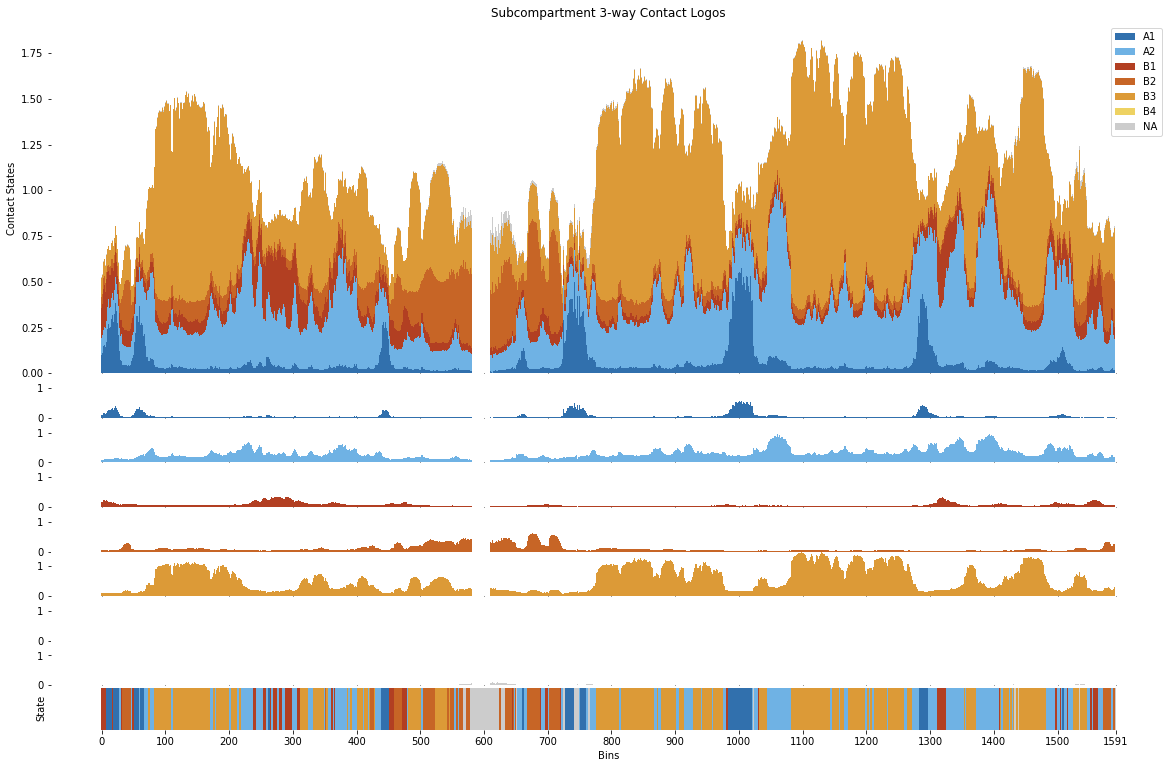

In [38]:
from hgmc.plots import plot_contact_logo

plot_contact_logo(
    triplet_subcompartment_logo,
    subcompartment_masks,
    subcompartment_features,
    [
        # A1 and A2
        '#3170ad',
        '#6fb2e4',
        # B1, B2, B3, and B4
        '#b23f22',
        '#c76526',
        '#dc9a37',
        '#eed262',
        # NA
        '#cccccc',
    ],
    title='Subcompartment 3-way Contact Logos',
    with_separate=True
)

In the above plot we're looking at subcompartments in chr7 at 100kb bins. The bottom track shows the subcomparent at each bin and the tracks above show with which other subcompartment the bins are in contact with according to the 3-way contact data.

The top track is following the principle of sequence logos. I.e., the overall height is given by the information content and the height of each bar section is equivalent to the relative frequency of the subcompartment multiplied by the information content. The heigher the bars the less equal is the distribution of subcompartments that are in contact with the bin.

Note that chr7 does not contain any B4 subcompartments, which is why we see an empty bar track in between the orange-yellow and gray bar track.

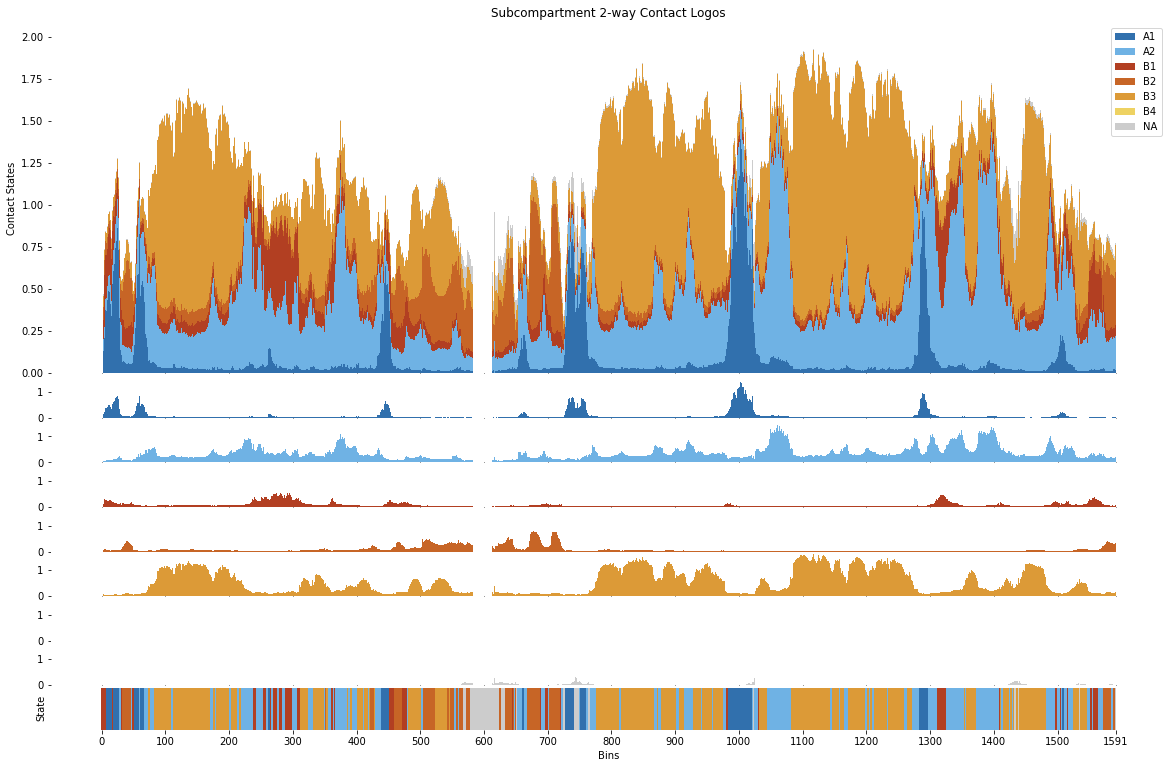

In [36]:
from hgmc.plots import plot_contact_logo

plot_contact_logo(
    pairs_subcompartment_logo,
    subcompartment_masks,
    subcompartment_features,
    [
        # A1 and A2
        '#3170ad',
        '#6fb2e4',
        # B1, B2, B3, and B4
        '#b23f22',
        '#c76526',
        '#dc9a37',
        '#eed262',
        # NA
        '#cccccc',
    ],
    title='Subcompartment 2-way Contact Logos',
    with_separate=True
)

## 3-way vs 2-way comparison

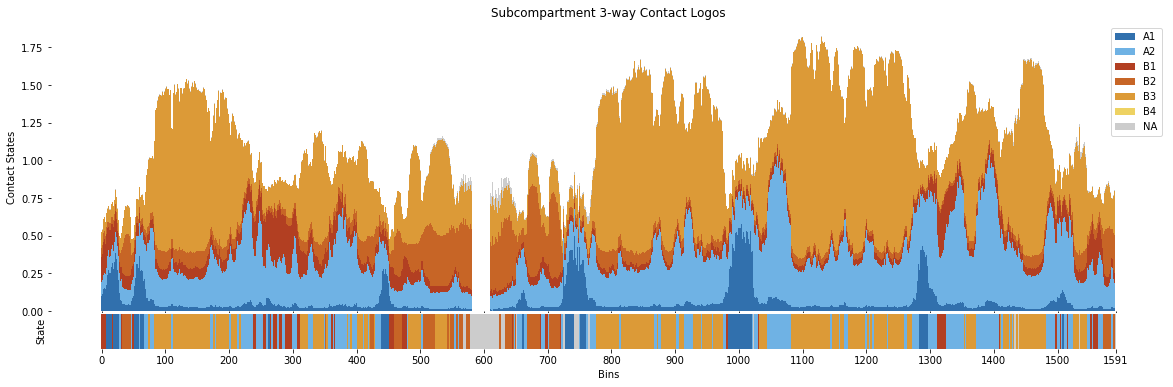

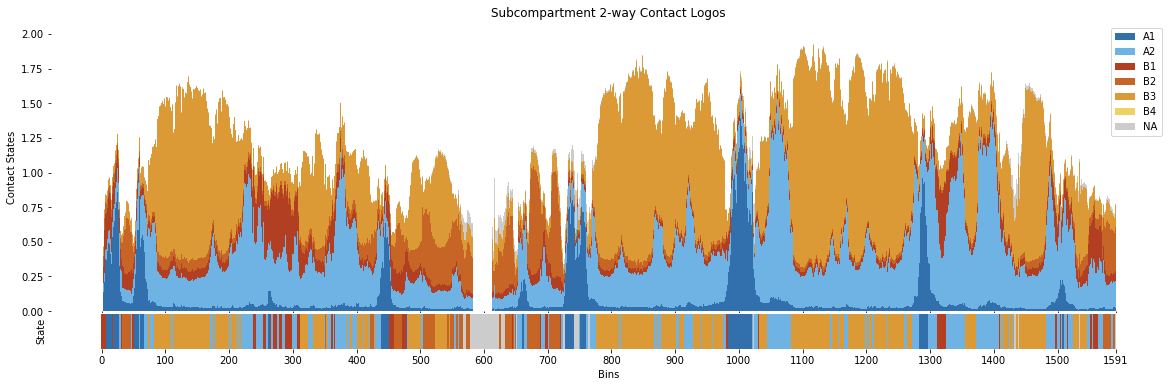

In [39]:
plot_contact_logo(
    triplet_subcompartment_logo,
    subcompartment_masks,
    subcompartment_features,
    [
        # A1 and A2
        '#3170ad',
        '#6fb2e4',
        # B1, B2, B3, and B4
        '#b23f22',
        '#c76526',
        '#dc9a37',
        '#eed262',
        # NA
        '#cccccc',
    ],
    title='Subcompartment 3-way Contact Logos',
)

plot_contact_logo(
    pairs_subcompartment_logo,
    subcompartment_masks,
    subcompartment_features,
    [
        # A1 and A2
        '#3170ad',
        '#6fb2e4',
        # B1, B2, B3, and B4
        '#b23f22',
        '#c76526',
        '#dc9a37',
        '#eed262',
        # NA
        '#cccccc',
    ],
    title='Subcompartment 2-way Contact Logos'
)